# Prerequisite: Install libraries
If you're running locally and have an AMD GPU, sorry, you're gonna have to figure out ROCm installation on your own.

If you're running locally, have an NVidia GPU, and use conda:

In [1]:
# Install libraries needed for this notebook--run this cell if running the notebook locally.
# Restart your Jupyter session afterwards, because of the ipywidgets installation.
# !conda install --yes numpy scikit-learn matplotlib tqdm cudatoolkit
# !conda install --yes pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
# !pip3 install -U transformers accelerate datasets ipywidgets bitsandbytes

If you're running this in Google Colab, a lot of libraries are pre-installed in the Colab runtime.  Run the following cell to install the remaining libraries, and then re-start your session just to be safe.

In [2]:
# !pip3 install -U accelerate datasets bitsandbytes

You may need to install `sentencepiece` and `protobuf` depending what models you're using.

In [3]:
# this one is maybe needed depending what model you use
# !pip3 install -U sentencepiece protobuf

# Preface: some libraries to know about

[Huggingface](https://huggingface.co/)'s [various Python libraries](https://huggingface.co//docs) are probably the best place to get started with LLMs, and what we'll be using today.  There's also [Langchain](https://www.langchain.com/), which is quickly getting more and more popular, but we won't be covering it today.

Some of the big libraries in the Huggingface ecosystem you should know about (click each library name to go to its documentation):
- [`transformers`](https://huggingface.co/docs/transformers/index): the library we'll be using.  General-purpose Transformer models for working with text.  (Almost all modern LLMs are based on the Transformer architecture).
- [`diffusers`](https://huggingface.co/docs/diffusers/index): like `transformers`, but for diffusion models, which output images and videos.
- [`accelerate`](https://huggingface.co/docs/accelerate/index): provides various optimizations for running models in Huggingface's other libraries.
- [`optimum`](https://huggingface.co/docs/optimum/index): provides various hardware-specific optimizations for Huggingface models.
- [`gradio`](https://www.gradio.app/docs): dashboard library, focused on deploying machine learning applications (not just LLMs).
- [`datasets`](https://huggingface.co/docs/datasets/index): lots and lots of datasets to play with!
- [`peft`](https://huggingface.co/docs/peft/index): provides various "parameter-efficient fine-tuning" methods that let you fine-tune big models with much lower RAM requirements.

We'll be using just `transformers`, `accelerate`, and `datasets`.  We'll also use the PyTorch models in `transformers`, though there are also Tensorflow and JAX models, and some `transformers`-specific training tools.  Feel free to explore those on your own time.

Compared to `scikit-learn` (from the last example), training PyTorch models takes more code.  None of it is particularly complicated, or particularly difficult.  The hard parts will be all the stuff around the code, rather than the code itself.

# Zero-shot classification with generative models

## Some major caveats and warnings

Generative models--while very cool, and shockingly good at doing one-shot and zero-shot learning, _should not be used blindly._  There are some _major_ concerns around their use.  A non-exhaustive list:

1. Data privacy.
    1. if you're using a model that isn't hosted locally, be sure you know their data privacy policies.  Uploading data to ChatGPT could be a violation of IRB protocols or data privacy laws.
    2. This is not an issue if you're hosting the the mode entirely locally.
3. Reproducibility.
    1. The same prompt won't always give the same results.  _This is the models working as they are supposed to.  It is impossible to fully prevent this behavior._  
    2. With local models you can set a fixed random seed for reproducibility.  _But reproducibility and correctness are not the same thing._
    3. Web-hosted models like ChatGPT might undergo significant changes with no notice.
4. Hallucinations.
    1. Generative models _are designed to hallucinate._  It is _mathematically impossible_ to prevent this without crippling the models.
    2. If accuracy is critical, _do not use these results without verifying them._  (At which point, you might not be saving yourself any work).
5. Output formats.
    1. Text-to-text models don't reliably produce machine-readable outputs.  You may have to do a lot of manual work or post-processing to convert text outputs into a machine-readable format, e.g. to do a statistical analysis on them.
6. Context windows.
    1. LLMs can only "remember" so much text.  This is less of an issue now than it used to be, but for very long texts, you may have to find a way to work around this limitation.
7. Instability.
    1. Small changes to your prompts might result in different outputs for each document.
    2. It is not possible to reason about how changes to the input will affect the output; these models are black boxes.
8. Cost.
    1. Generative LLMs aren't free.  They require _very_ high compute resources to run efficiently.  You're either buying GPUs, renting compute from somewhere like AWS, or paying a per-token price for API calls to something like ChatGPT.  This can get very expensive very quickly for some projects.
8. Factual accuracy.
   1. _LLMs do not have a notion of factual accuracy._  They only compute a _probable_ continuation of the text, _based on their training data_.  This can result in output that has the form of a factually true statement, _but the model is not aware of "factual accuracy" in either the inputs or outputs._
9. Meta-linguistic references and math.
    1. Generative models are consistently _awful_ at doing math, or at 

Generative models are not magic, they are not oracles, they are not universal problem solvers, they are not knowledge bases.  They are tools that generate text that looks like their training data.  Everything else they can do, while extremely impressive and very interesting, _is a happy accident._

_However,_ they still have some very compelling and interesting use cases.  We'll explore one of them here: zero-shot classification.

# Zero-Shot Classification

"Zero-shot classification" = making predictions by describing the task, or describing the different categories, without providing labeled data.  Zero-shot classification is _hard_, but LLMs are surprisingly good at it--with some important caveats that we'll see in a bit.  Generative LLMs in particular show a lot of promise for this kind of application, which is where we'l focus for this notebook.

# Data and prediction task

Just to keep it simple, we'll do a classic sentiment analysis task.  We'll pull a dataset of Yelp reviews, keep only the 1 and 5 star reviews, and ask a model to predict if this is a positive (5-star) or negative (1-star) review.

We're intentionally keeping it simple for this workshop; you can use the same general steps we show here with far more complicated tasks, but the general design of the code won't change much.

In [4]:
import datasets
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# use the smaller (10k reviews per star rating) test set--just for speed
data = datasets.load_dataset("yelp_review_full", split="test")

y = np.array(data["label"])
x = np.array(data["text"])

# only 1/5 star reviews.  Coded as 0-4 in the dataset.
keep = (y == 0) | (y == 4)
x = x[keep]
y = y[keep]

# convert to 0/1
y = (y / 4).astype(int)

data = pd.DataFrame({
    "Text": x,
    "Ground Truth": y,
})

# Pick and load a model

Next, we'll need to pick and load a model.  We'll pick a model designed for chat-type texts.  These tend to generate output that works well for zero-shot classification.

These are _big_ models, though, so we need to do some tricks to be able to run them.  We'll use _quantization_.  This allows loading the model in _very_ low-precision numeric formats that should only have a minor impact on the final behavior.  (Other tricks might work better depending on your specific hardware, but this allows us to run the models with very low VRAM usage).

The code below uses the Huggingface-trained model, Zephyr-7b-beta.  This model doesn't give the best results from my testing, but the other models require accepting the models' licenses.  You also need a Huggingface account, and you need to set up your Huggingface credentials in your environment to access them, after accepting their terms.  After doing that, though, switching models is as simple as changing what lines below are and aren't commented out; the rest of the code doesn't change at all.

In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# recommended models--try both!
# model_name = "HuggingFaceH4/zephyr-7b-beta"
model_name = "HuggingFaceH4/mistral-7b-sft-beta"

# Mistral v0.3 tends to do better than HuggingFace's versions in my experience,
# but these are gated models.  You need a Huggingface account to access them,
# and need to accept their terms of use (basically just agreeing to the Apache
# 2.0 license terms, which are absurdly permissive).
# model_name = "mistralai/Mistral-7B-v0.3"
# model_name = "mistralai/Mistral-7B-Instruct-v0.3"

# Mixtral models are "mixture of experts" models.  Very good results, but also
# gated models, and the can be trickier to run.
# model_name = "mistralai/Mixtral-8x7B-v0.1"
# model_name = "mistralai/Mixtral-8x7B-Instruct-v0.1"

# Llama-3 is the current big hyped up model, but it is also gated and requires
# a bit more to access.
# model_name = "meta-llama/Meta-Llama-3-8B"
# model_name = "meta-llama/Meta-Llama-3-8B-instruct"

tok = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    # trick 1: quantization.  Makes the model a lot smaller --> uses less VRAM and is easier to run.
    # This will also handle device offloading, so some of the model will be executed on the GPU,
    # some on the CPU.  This results in slowdowns as data is copied between devices.
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
    ),
    # set this explicitly to silence a warning
    low_cpu_mem_usage=True,
    
    # trick 2: use flash attention to speed up the self-attention block.  Only works if you're
    # on an NVidia Ampere or newer card.  You'll need to install the `flash-attn` library with pip,
    # which can be a bit tricky to get working.
    # attn_implementation="flash_attention_2",

    # trick 3: use 16-bit floats, INSTEAD of quantization.
    # `torch.float16` is a basic 16-bit float. Halves the memory usage of the models,
    # but they still need a lot of memory to run.  Try this if you have an older GPU
    # with a lot of VRAM.
    # torch_dtype=torch.float16
)
# put the model in evaluation mode; this won't track gradients and should speed things
# up a bit compared to being in training mode.
model.eval()

# only use .to("cuda") if you can fit the whole model onto your GPU and are NOT using
# quantization.  (or, feel free to try using it WITH quantization, but expect some
# possible issues).
# model = model.to("cuda")

# optional code to compile the model
# import sys
# if sys.version_info.minor <= 12 or torch.__version__.split(".")[1] >= "4":
#     clf = torch.compile(clf)
# else:
#     print(
#         f"Cannot compile the model.  Need a Python version *prior to* 3.12 (you have: {sys.version}), or "
#         f"a PyTorch version 2.4.0 or later (you have: {torch.__version__}"
#     )

# if we don't specify the padding token ID, we'll get a bunch of warnings about it being
# set automatically when we run inference.  This isn't a problem for the results, it's 
# just a bunch of extraneous output we don't want to see if we can avoid it.
model.generation_config.pad_token_id = tok.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Prep work: prompts

Instruction-tuned models, and chat models generally, need some sort of prompt to guide the text they generate.  We'll handle this in a pretty simple way: we'll just use a "carrier phrase" for each review, which will provide instructions on what we want the model to do.  For every review, we'll embed the review text into this carrier phrase and send it to the model.

_Note:_ the model is not "following instructions," per se.  The model is continuing to generate text that looks like it would come after the text the user provides.  For most good instruction-tuned models, this ends up generating text that looks like it's following instructions.

In [6]:
# our "carrier phrase" which is written in the form of instructions for the model to carry out.
prompt = (
    "Please identify the sentiment of the following review: {}"
)

# A sample review--crafted to have an ambiguous sentiment--that we'll use for some demos.
review = (
    "'Hex; Or Printing In The Infernal Method' is the fourth album from the legendary "
    "drone metal band, Earth, and a radical departure from their previous style, which "
    "is likely to upset many die-hard fans.  Gone are the walls of guitar distortion, "
    "replaced with a more country-influenced sound with clearly defined, slow, and "
    "repetitive riffs.  The album is no less heavy than their previous releases, and is "
    "like to be a controversial entry into the band's catalog."
)

# Now create the messages in a "chat template".  The template is different for each model,
# but the tokenizer can convert things for it.  We just need to set the data up first.
# Note: different models will have different roles available.  "user" and "assistant"
# are common.  Some models have a "system" role.  We could pass several messages, alternating
# between user and assistant, to generate a "backlog" of messages to further bias the model
# towards a particular kind of output, but we'll just provide the user message here.
messages = [
    {"role": "user", "content": prompt.format(review)} ,
]
# format the messages into the expected chat format
model_inputs = tok.apply_chat_template(
    messages,
    return_tensors="pt",
    return_dict=True,
)

# run the prepared texts through the model and get the outputs.
generated_ids = model.generate(
    # input data
    **{k:v.to("cuda") for k,v in model_inputs.items()},
    # stop asking for more tokens after 256 tokens
    max_new_tokens=256,
    # sample randomly from high-likelihood next tokens
    do_sample=True,
)

# the outputs are currently just a tensor of numeric IDs, each corresponding to a
# token in the model's vocabulary.
print("GENERATED_IDS:")
print(generated_ids)

# The tokenizer can decode these numeric IDs into human-readable strings.
print("\nDECODED TEXT:")
print(tok.batch_decode(generated_ids)[0])

C:\Users\andersonh\AppData\Local\miniconda3\envs\LASI\Lib\site-packages\transformers\models\mistral\modeling_mistral.py:674: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


GENERATED_IDS:
tensor([[  523, 28766,  1838, 28766, 28767,    13, 12069,  9051,   272, 21790,
           302,   272,  2296,  4058, 28747,   464, 21934, 28745,  1667, 13281,
           288,   560,   415,   560,   642,  2340, 10011, 28742,   349,   272,
         10036,  4708,   477,   272, 26361,  1605,   538,  7503,  4028, 28725,
          8599, 28725,   304,   264, 14358, 20622,   477,   652,  3454,  3238,
         28725,   690,   349,  3917,   298, 13265,  1287,  1202, 28733,  8896,
          8504, 28723, 28705,   420,   538,   460,   272,  8133,   302, 10686,
          1255, 25382, 28725,  8939,   395,   264,   680,  2939, 28733,   262,
         17262,  4697,  2622,   395,  6315,  4057, 28725,  3944, 28725,   304,
         21435,  2468, 12950,  2547, 28723, 28705,   415,  4708,   349,   708,
          2108,  5917,   821,   652,  3454, 21446, 28725,   304,   349,   737,
           298,   347,   264, 24720,  4905,   778,   272,  4028, 28742, 28713,
         18255, 28723,     2, 28705, 

# Post-processing the output

Notice how we have both our input and the model's response in a single string.  We need to do a little work to parse this out.  All models have some way to indicate when the "speaker" changes; Zephyr uses `<|system|>`, `<|user|>`, and `<|assistant|>` to mark the start of the system, user, and assistant texts, respectively, and uses `</s>` to mark the end of an entire dialog.  We can use this to parse out the different dialog "turns" and just show the model's response.

_Note_: in the Huggingface library, the tokenizers have a special attribute--`added_tokens_decoder`--which you can user to programmatically get all special tokens that the model/chat template might add.  We won't use that for this code, and will instead hard-code the particular tokens we're interested in.

We'll also wrap the above logic up into a function to make life a bit easier later on.

In [7]:
import re
from textwrap import wrap

def annotate(carrier_phrase, text, model=model, tok=tok):
    """Run the text `text` through the model `model`, and capture just the model's output."""
    # format the carrier phrase with the `text` input and apply the chat template.
    messages = [
        {"role": "user", "content": carrier_phrase.format(text)}
    ]
    model_inputs = tok.apply_chat_template(
        messages,
        return_tensors="pt",
        return_dict=True,
    )
    
    # get the model's responses
    generated_ids = model.generate(
        **{k:v.to("cuda") for k,v in model_inputs.items()},
        max_new_tokens=256,
        do_sample=True,
    )
    output = tok.batch_decode(generated_ids)[0]
    
    # split the text into system, user, and assistant chunks.
    if model_name in ("HuggingFaceH4/zephyr-7b-beta", "HuggingFaceH4/mistral-7b-sft-beta"):
        # sanity check: sometimes the tokens we want don't appear.
        if "<|user|>" not in output or "<|assistant|>" not in output:
            return "", ""
        output = re.split(r"(<\|user\|>|</s>|<\|system\|>|<\|assistant\|>)", output)
        user = output.index("<|user|>")
        assistant = output.index("<|assistant|>")
    elif model_name in ("mistralai/Mistral-7B-v0.3", "mistralai/Mistral-7B-Instruct-v0.3", "mistralai/Mixtral-8x7B-v0.1"):
        if "[INST]" not in output or "[/INST]" not in output:
            return "", ""
        output = re.split(r"(\[INST\]|\[/INST\]|</s>)", output)
        user = output.index("[INST]")
        assistant = output.index("[/INST]")
    else:
        raise ValueError(
            f"Oops, you need to add logic for the outputs from {model_name}."
            "You'll need to add logic to identify the start/end tokens for user "
            "and assistant roles."
        )

    user_input = wrap(output[user + 1].strip(), subsequent_indent="\t")
    model_response = wrap(output[assistant + 1].strip(), subsequent_indent="\t")
    return "\n".join(user_input), "\n".join(model_response)

# Caution: Non-deterministic outputs

Let's run our sample review through this new logic a few times, and see how different the results are across a few different runs.

In [8]:
for i in range(10):
    _, label = annotate(prompt, review, model=model, tok=tok)
    print(f"Annotation number {i+1}")
    print(f"\tMODEL SAYS: {label.strip()}")
    print()

Annotation number 1
	MODEL SAYS: The sentiment of the review is likely positive or neutral, as the
	reviewer indicates that the album is no less heavy than Earth's
	previous releases and is likely to appeal to fans of other musical
	genres beyond drone metal. However, the reviewer notes that the
	radical departure from the band's previous style may upset some die-
	hard fans of the drone metal genre. Therefore, the reviewer's
	sentiment may fall somewhere between enjoyment of the album as a
	creative exploration and understanding of the possible frustrations
	some longtime fans may experience.

Annotation number 2
	MODEL SAYS: The sentiment of the review is positive towards the new style of
	Earth's album.

Annotation number 3
	MODEL SAYS: The sentiment of the following review is neutral.

Annotation number 4
	MODEL SAYS: The sentiment of the review is neutral, as it provides a balanced
	assessment without expressing any explicit positive or negative
	opinions.

Annotation number 5
	MO

This is going to be less of a problem with some models than others, but it _is not possible_ to guarantee that the same model will have the same outputs for a given input, when run multiple times.

# Prompt Engineering

The model's output is pretty verbose.  This might be fine if we're manually reading them and putting values into a spreadsheet, but it would be nice if we could get machine-readable output directly from the model.  We can try to bias the model's outputs by "engineering" the prompt to do what we want--hence, "prompt engineering."

Some notes about prompt engineering:
- A good starting point: just add extra instructions to the prompt to tell the model what you want it to do.  Despite the models not actually "following directions," this can work surprisingly well.
- Sometimes you need to repeat the same instructions a few times to really hammer the point home.
- This is a _very_ fiddly process.  There is no "best" prompt (and no real way to evaluate the quality of prompts), and most of the tweaking ends up being educated guesswork.  It'll also be different for each model.  You can build a good intiution for what to do with your prompts, but there's still a lot of guess-and-check.
- _You may not be able to make the model do what you want._  It isn't always possible to force its output into a desired form.
- You might end up making the outputs worse.  There's no way to know until you try.

We'll do the simple thing: we'll tell the model to just say 0 or 1, and not explain its reasoning.  We'll see how that goes.

In [9]:
prompt = (
    "Please identify whether the following text is primarily positive or negative "
    "in sentiment.  If it is primarily positive, say '1'.  if it is primarily negative, "
    "say '0'.  Do not explain your reasoning, and only provide the number corresponding "
    "to the sentiment.  The text is: {}"
)

for i in range(10):
    print(f"Annotation number {i+1} for the Earth review")
    _, label = annotate(prompt, review, model=model, tok=tok)
    print(f"\tMODEL SAYS: {label.strip()}")
    print()

Annotation number 1 for the Earth review
	MODEL SAYS: 0

Annotation number 2 for the Earth review
	MODEL SAYS: The sentiment is primarily negative, so the number is 0.

Annotation number 3 for the Earth review
	MODEL SAYS: 0

Annotation number 4 for the Earth review
	MODEL SAYS: The sentiment is positive.  To be specific, the text does not focus on
	the positive or negative elements of the album, and instead is
	descriptive. It describes the change in the band's style and the
	likely response from diehard fans, while also acknowledging that the
	album is no less heavy than their previous releases. Therefore, it
	does not give a positive or negative sentiment about the album, and
	should be given a neutral ranking. The final text may be described as
	neutral.

Annotation number 5 for the Earth review
	MODEL SAYS: 0

Annotation number 6 for the Earth review
	MODEL SAYS: 0

Annotation number 7 for the Earth review
	MODEL SAYS: 0 (Negative)

Annotation number 8 for the Earth review
	MODEL 

Well, that worked a bit better--not perfect, but better than it was before.  Now let's run this over our actual data and compare the model to the ground truths.

In [10]:
# now, on our actual review data
for _, row in data.iloc[:10].iterrows():
    text = row["Text"]
    ground_truth = row["Ground Truth"]
    _, label = annotate(prompt, text, model=model, tok=tok)
    print("-" * 20)
    print(f"TEXT: {text}")
    print(f"\nMODEL SAYS: {label}")
    print(f"\nGROUND TRUTH: {ground_truth}")
    print("-" * 20)

--------------------
TEXT: I got 'new' tires from them and within two weeks got a flat. I took my car to a local mechanic to see if i could get the hole patched, but they said the reason I had a flat was because the previous patch had blown - WAIT, WHAT? I just got the tire and never needed to have it patched? This was supposed to be a new tire. \nI took the tire over to Flynn's and they told me that someone punctured my tire, then tried to patch it. So there are resentful tire slashers? I find that very unlikely. After arguing with the guy and telling him that his logic was far fetched he said he'd give me a new tire \"this time\". \nI will never go back to Flynn's b/c of the way this guy treated me and the simple fact that they gave me a used tire!

MODEL SAYS: Please enter a number (1 or 0) to identify the primary sentiment of
	the text:  1 or 0:

GROUND TRUTH: 0
--------------------
--------------------
TEXT: Don't waste your time.  We had two different people come to our house to 

Great!  Now we can have the model run over all of our texts and label them, with no need to do any labeling ourselves.  _Crucial caveat:_ even though our prompt includes instructions to only reply with a number, 0/1/2, _we cannot guarantee that the model's outputs will always be what we requested._  So you may run into some issues if you blindly assume that the output will always be an integer.

_Crucial caveat:_ these models are _non-deterministic_.  The same inputs might yield different outputs.  We can see that by running the same text through the model a few different times.

In [11]:
import numpy as np
from tqdm.notebook import tqdm

# create the column for storing the "raw" response from the model.
# If it already exists--e.g. if you're re-running this call--then don't.
# This avoids overwriting pervious runs' outputs.
if "Zero-shot Label" not in data:
    data["Zero-shot Label"] = ""

# only the first 100 documents--otherwise this will take many, many hours to run.
# This will still take a while, though.
for i in tqdm(data.index[:100]):
    # skip any texts already annotated--in case we re-run this code a few times
    if data.loc[i, "Zero-shot Label"] != "":
        continue
    _, label = annotate(prompt, data.loc[i, "Text"], model=model, tok=tok)
    data.loc[i, "Zero-shot Label"] = label

# try converting everything to an int and see if it causes any problems--
# this will result in some missing values in most cases!
def try_convert(maybe_int):
    try:
        return int(maybe_int.strip())
    except ValueError:
        return np.nan
data["Converted Zero-shot Label"] = data["Zero-shot Label"].map(try_convert)

  0%|          | 0/100 [00:00<?, ?it/s]

Successfully converted 50/100 outputs to numeric values
F1: 0.8599439775910365
Ground Truth
0    26
1    24
Name: count, dtype: int64
Converted Zero-shot Label
1.0    27
0.0    23
Name: count, dtype: int64


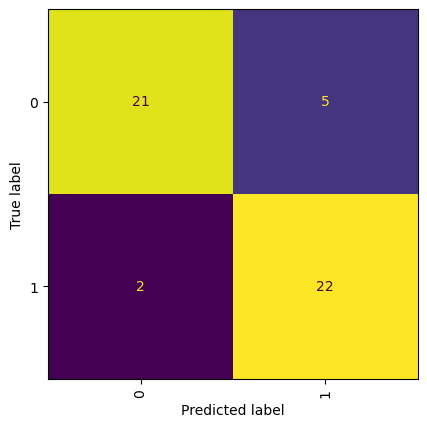

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

preds = data[data["Zero-shot Label"] != ""]

print(f"Successfully converted {data['Converted Zero-shot Label'].count()}/{preds.shape[0]} outputs to numeric values")

# check some error metrics
from sklearn.metrics import f1_score
preds = preds.dropna()
f1 = f1_score(preds["Ground Truth"], preds["Converted Zero-shot Label"], average="macro")
print(f"F1: {f1}")

print(preds["Ground Truth"].value_counts())
print(preds["Converted Zero-shot Label"].value_counts())
fix, ax = plt.subplots()
cm = ConfusionMatrixDisplay.from_predictions(
    y_true=preds["Ground Truth"].astype(int),
    y_pred=preds["Converted Zero-shot Label"].astype(int),
    xticks_rotation="vertical",
    ax=ax,
    colorbar=False,
)
plt.show()

# Some concluding notes

The above answers will be a bit worse than they could be for a few reasons:
- The models we used have 7 billion parameters.  This is on the small side for most generative models.  Larger models might give more consistent results, but be _extremely_ difficult to actually run.  And extremely slow.
- Quantization can effect text generation a bit more than other tasks.  Text generation is a lot more sensitive to initial conditions.  (this is likely not a _huge_ effect
- We didn't do a whole lot with prompt engineering.  E.g., we didn't provide a "system" message, which might have provided better results.
- We didn't tweak any of the generation options, like the `temperature` or `top_k` values (we left these at the defaults).
- Other models than Zephyr might give better results.  Mistral v0.3-instruct and Llama-3 might be good candidates to try.

We could do a few things with these results.  We could use them to jump-start a classifier model, or use them as suggestions for a human coder working through a lot of data (spot-checking can be easier than labelling from scratch!).